In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, Reshape, Conv2D, Flatten, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, ZeroPadding2D, Conv2DTranspose
from keras import layers
from keras import models
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import time

Using TensorFlow backend.


In [21]:
BASEPATH = "data/"
BATCH_SIZE = 32
EPOCHS = 100
SIZE = 64
NOISE_INPUT = 200

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 65536)             13107200  
_________________________________________________________________
batch_normalization_22 (Batc (None, 65536)             262144    
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 65536)             0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 16, 16, 128)       0         
__________

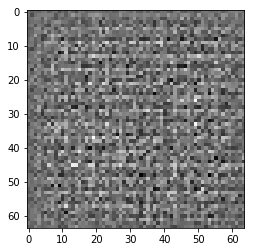

In [22]:
def make_generator_model():
    model = Sequential()
    model.add(layers.Dense(SIZE//4*SIZE//4*256, use_bias=False, input_shape=(NOISE_INPUT,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((SIZE//4, SIZE//4, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    model.compile(Adam(1e-4), loss="binary_crossentropy")

    return model
g=make_generator_model()

g.summary()

generator = make_generator_model()

noise = tf.random.normal([1, NOISE_INPUT])
generated_image = generator.predict([noise], steps=1)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [30]:
def make_discriminator_model():
    model = Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[SIZE, SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

d = make_discriminator_model()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 32768)             0         
__________

Found 202599 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 64, 64, 3)


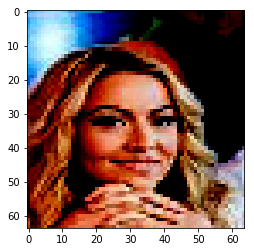

In [31]:
def load_data():
    gen = ImageDataGenerator(preprocessing_function=lambda image: (image - 127.5)/127.5)
    gen = gen.flow_from_directory(
            BASEPATH,
            target_size=(SIZE, SIZE),
            batch_size=BATCH_SIZE)
    
    return gen
    
def next_batch(real_generator):
    n = next(real_generator)
    return n[0] # .reshape(-1,SIZE*SIZE*3)

real_gen = load_data()
batch = next_batch(real_gen)
print(batch.shape)
plt.imshow(batch[0])

In [32]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(NOISE_INPUT,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 200)               0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 64, 64, 3)         14398912  
_________________________________________________________________
sequential_21 (Sequential)   (None, 1)                 242561    
Total params: 14,641,473
Trainable params: 14,267,456
Non-trainable params: 374,017
_________________________________________________________________


In [33]:
def plot_generated_images(epoch, generator, examples=20, dim=(5,4), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, NOISE_INPUT])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples,SIZE,SIZE,3)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(((generated_images[i]+1)*127.5).astype(np.uint8), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gans_images/celeba-face.{:05.0f}.png'.format(epoch))

Found 202599 images belonging to 2 classes.
Epoch 1
Found 202599 images belonging to 2 classes.
Epoch 00001 [D loss: 0.304, acc.: 092.2%] [G loss: 0.602]
Epoch 2
Found 202599 images belonging to 2 classes.
Epoch 00002 [D loss: 0.503, acc.: 087.5%] [G loss: 0.373]
Epoch 3
Found 202599 images belonging to 2 classes.
Epoch 00003 [D loss: 0.482, acc.: 078.1%] [G loss: 0.643]
Epoch 4
Found 202599 images belonging to 2 classes.
Epoch 00004 [D loss: 0.776, acc.: 060.9%] [G loss: 0.589]
Epoch 5
Found 202599 images belonging to 2 classes.
Epoch 00005 [D loss: 0.356, acc.: 085.9%] [G loss: 0.351]
Epoch 6
Found 202599 images belonging to 2 classes.
Epoch 00006 [D loss: 0.183, acc.: 093.8%] [G loss: 0.339]
Epoch 7
Found 202599 images belonging to 2 classes.
Epoch 00007 [D loss: 0.530, acc.: 078.1%] [G loss: 0.639]
Epoch 8
Found 202599 images belonging to 2 classes.
Epoch 00008 [D loss: 0.998, acc.: 062.5%] [G loss: 0.980]
Epoch 9
Found 202599 images belonging to 2 classes.
Epoch 00009 [D loss: 0.2

Epoch 00074 [D loss: 0.104, acc.: 095.3%] [G loss: 1.225]
Epoch 75
Found 202599 images belonging to 2 classes.
Epoch 00075 [D loss: 0.044, acc.: 098.4%] [G loss: 0.626]
Epoch 76
Found 202599 images belonging to 2 classes.
Epoch 00076 [D loss: 0.173, acc.: 093.8%] [G loss: 1.288]
Epoch 77
Found 202599 images belonging to 2 classes.
Epoch 00077 [D loss: 0.063, acc.: 096.9%] [G loss: 1.125]
Epoch 78
Found 202599 images belonging to 2 classes.
Epoch 00078 [D loss: 0.044, acc.: 096.9%] [G loss: 0.756]
Epoch 79
Found 202599 images belonging to 2 classes.
Epoch 00079 [D loss: 0.000, acc.: 100.0%] [G loss: 14.506]
Epoch 80
Found 202599 images belonging to 2 classes.
Epoch 00080 [D loss: 0.266, acc.: 090.6%] [G loss: 1.912]
Epoch 81
Found 202599 images belonging to 2 classes.
Epoch 00081 [D loss: 0.113, acc.: 096.9%] [G loss: 6.978]
Epoch 82
Found 202599 images belonging to 2 classes.
Epoch 00082 [D loss: 0.055, acc.: 096.9%] [G loss: 0.853]
Epoch 83
Found 202599 images belonging to 2 classes.


KeyboardInterrupt: 

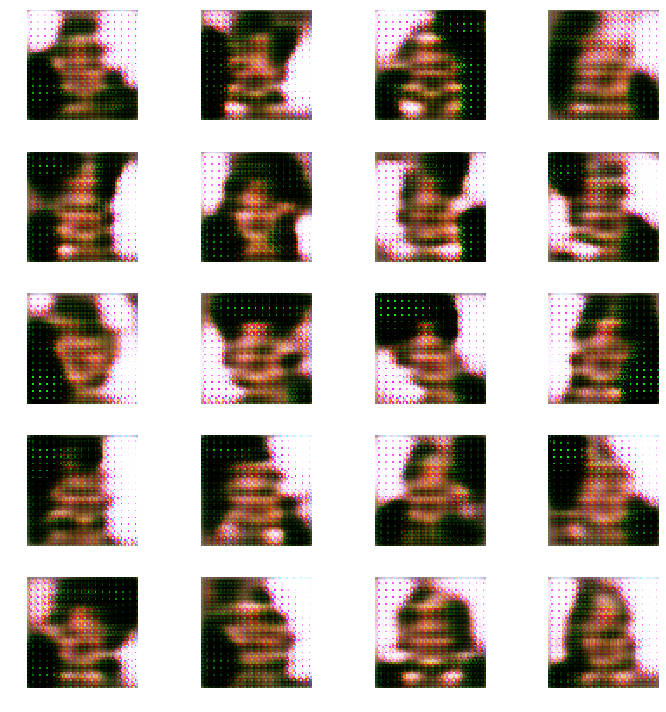

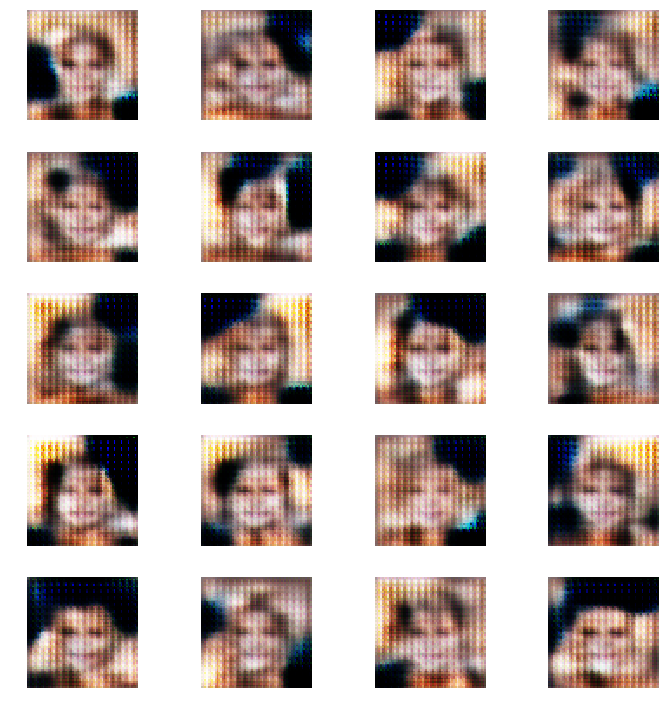

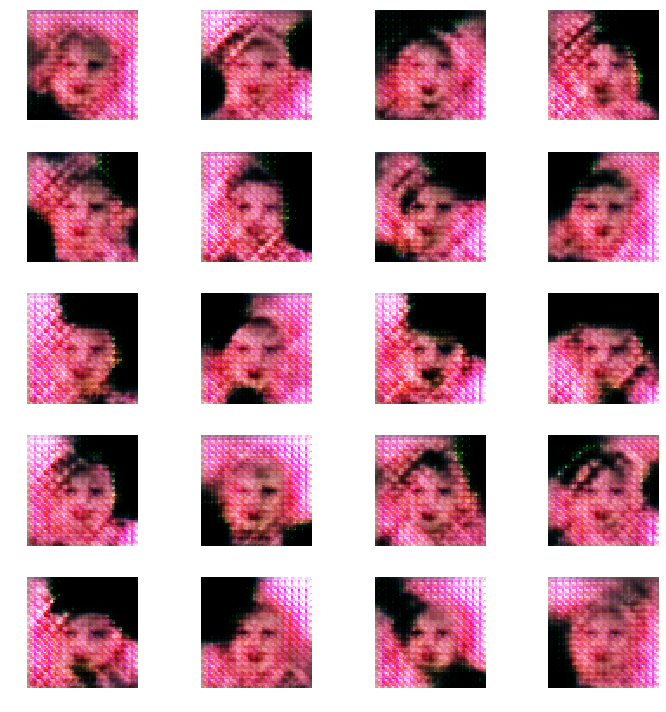

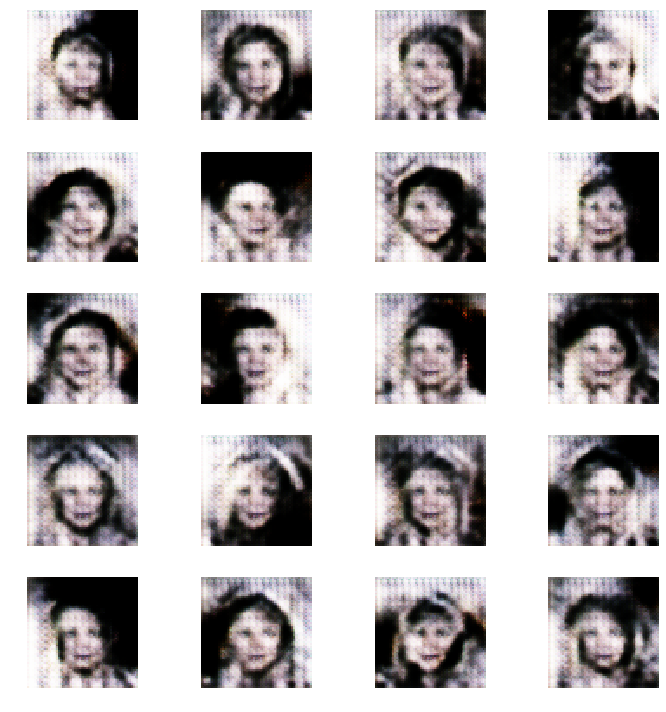

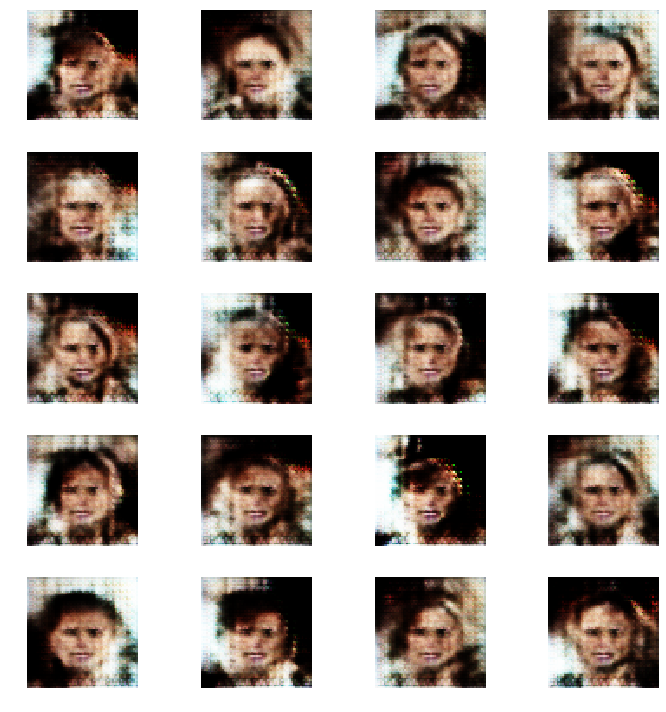

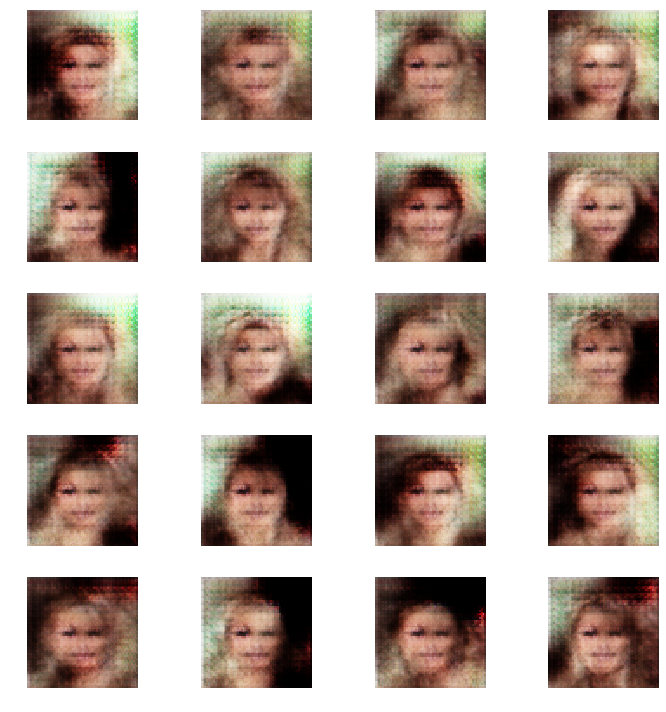

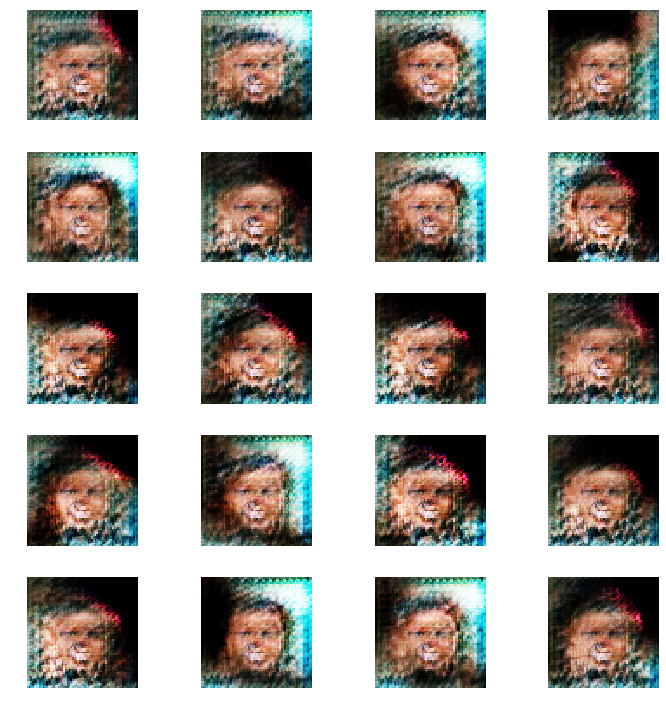

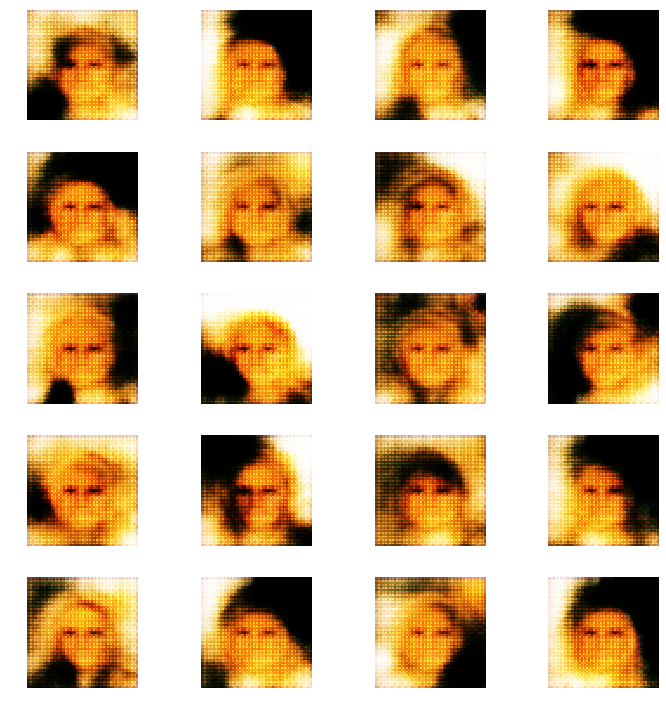

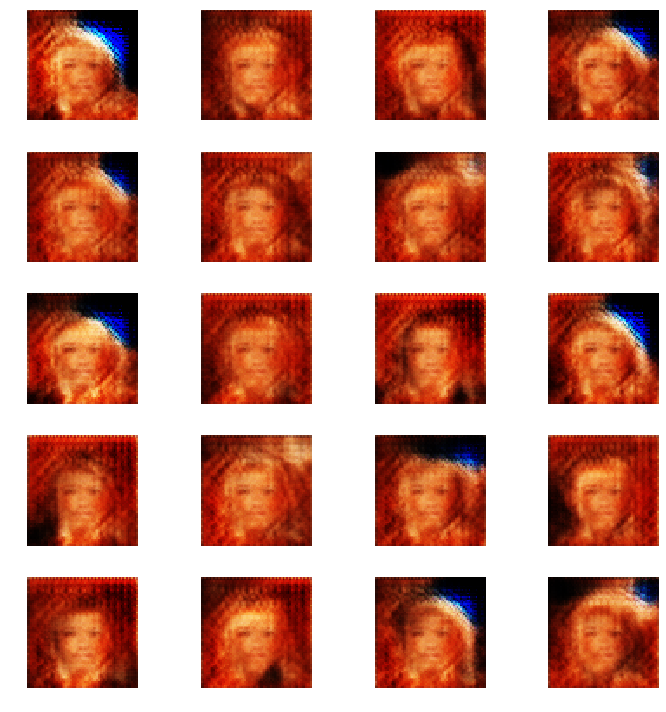

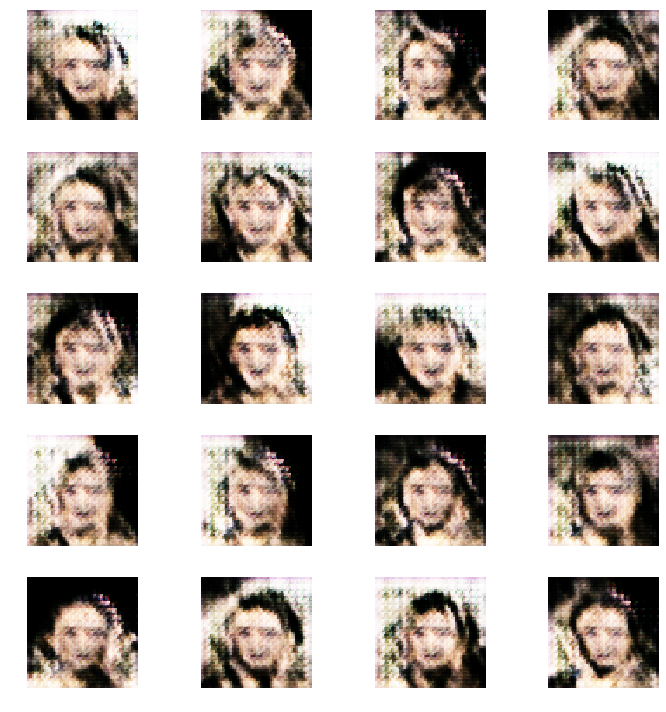

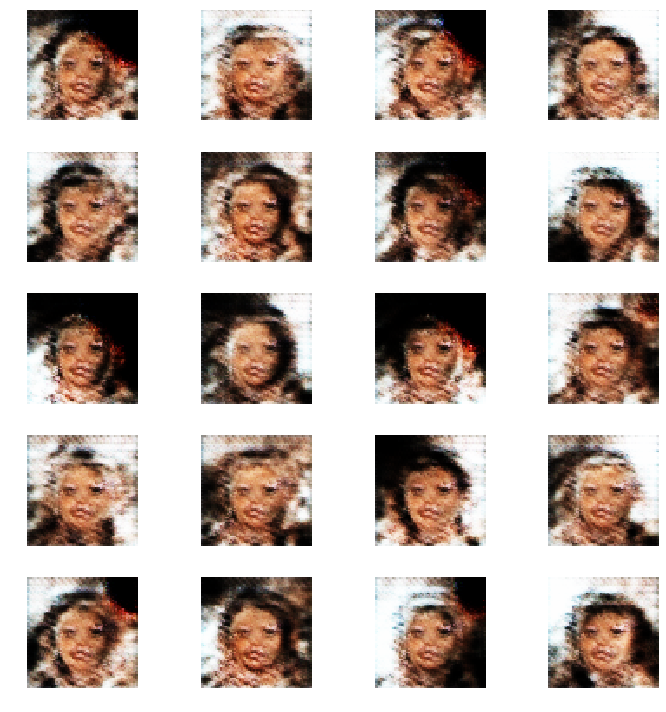

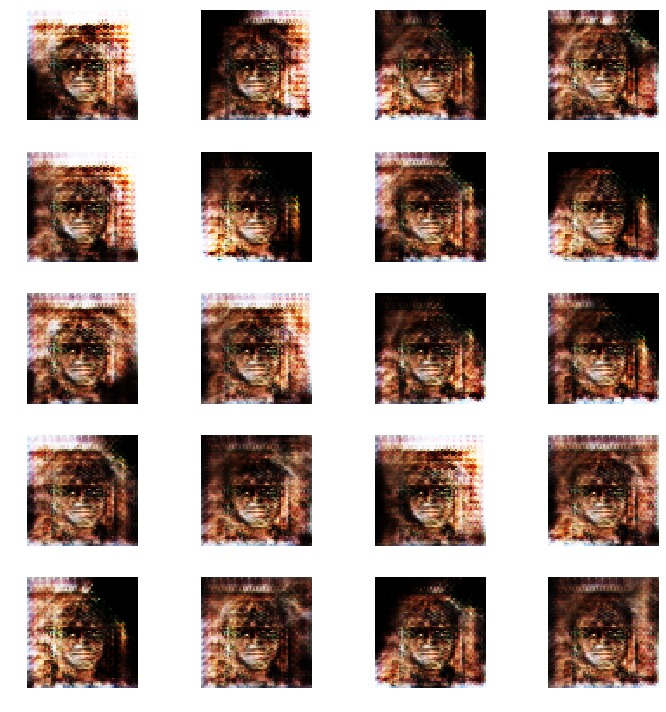

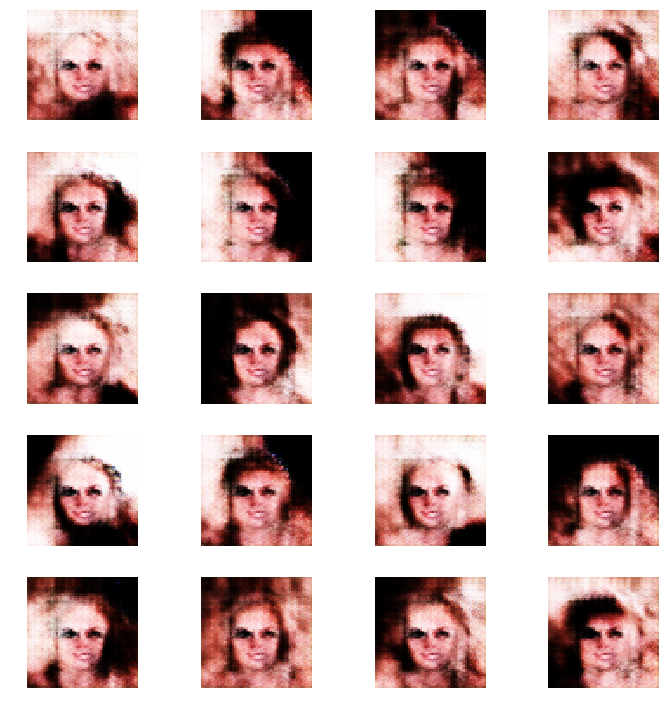

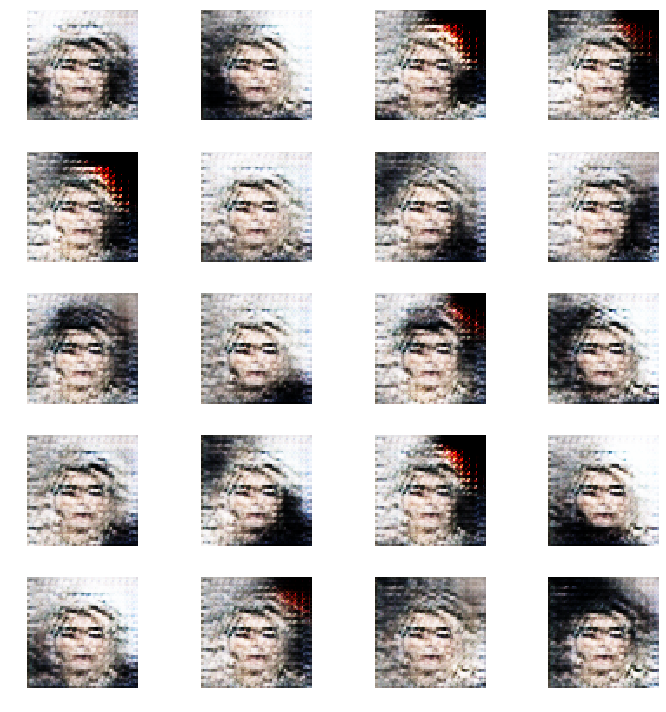

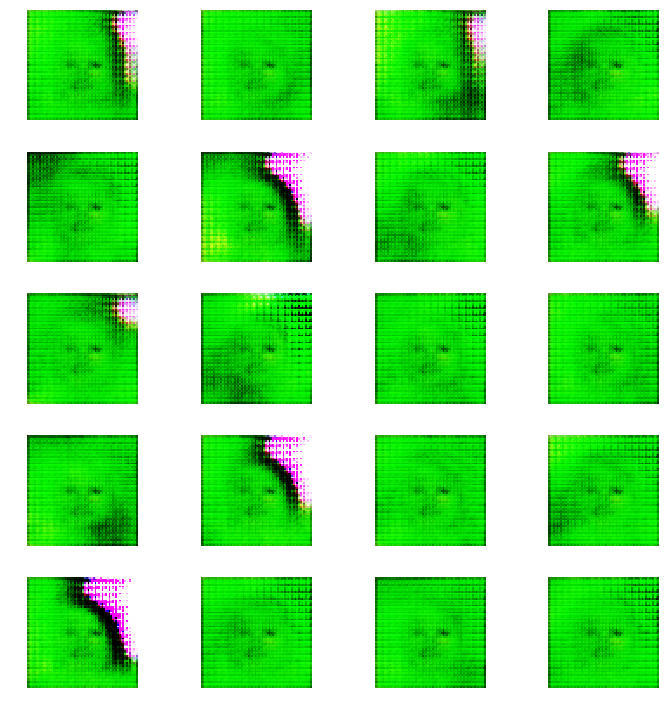

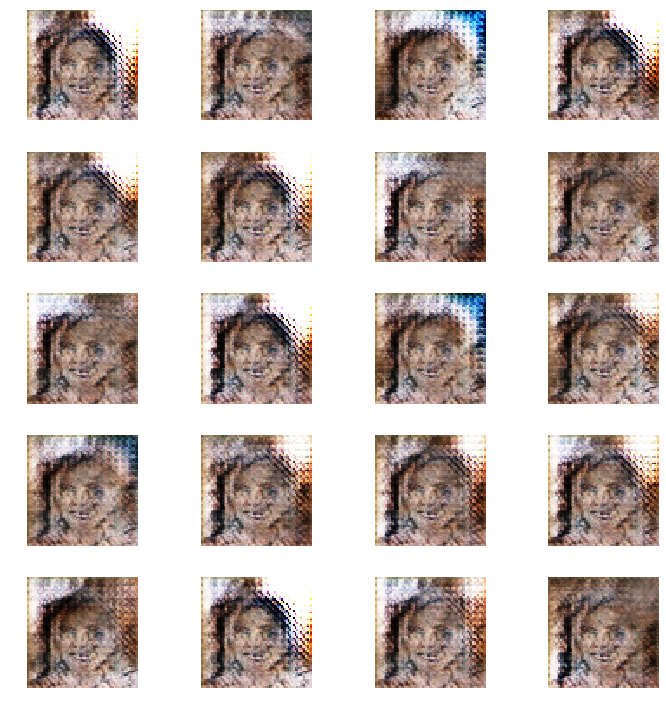

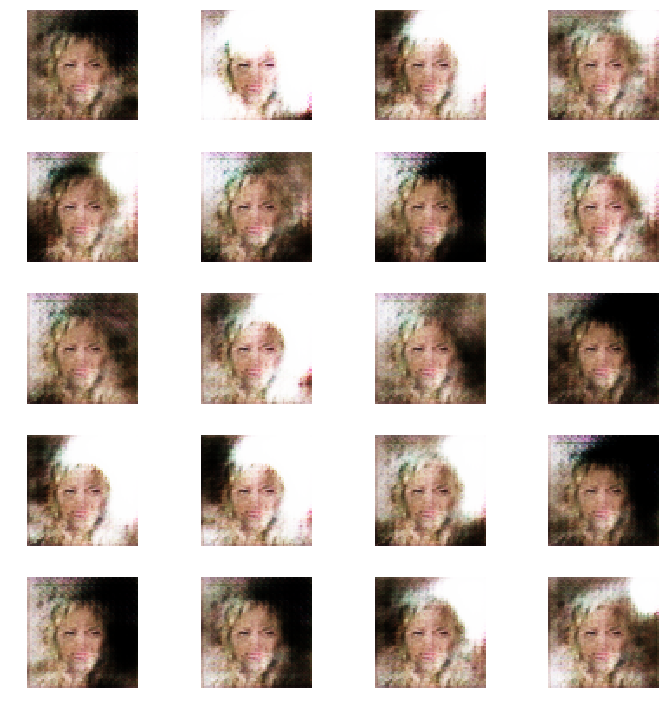

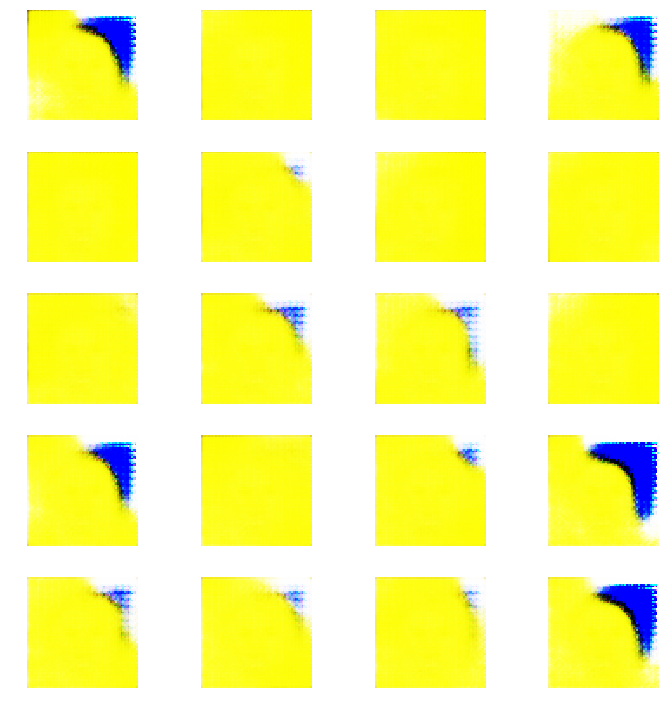

In [34]:
def training(epochs=1):
    
    #Loading the data
    real_gen = load_data()
    batch_count = real_gen.samples // BATCH_SIZE // 10
    
    # Creating GAN
    generator= make_generator_model()
    discriminator= make_discriminator_model()
    gan = create_gan(discriminator, generator)
    
    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        real_gen = load_data()
        
        for _ in range(batch_count-1):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [BATCH_SIZE, NOISE_INPUT])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch = next_batch(real_gen)
            
            #Construct different batches of  real and fake data 
            X = np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*BATCH_SIZE)
            y_dis[:BATCH_SIZE]=1
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            
            d_loss = discriminator.train_on_batch(X, y_dis)
            #print(d_loss)
            
            #y_dis[:BATCH_SIZE]=1
            #print(discriminator.evaluate(X, y_dis))
            
            #Tricking the noised input of the Generator as real data
            noise = np.random.normal(0,1, [BATCH_SIZE, NOISE_INPUT])
            y_gen = np.ones(BATCH_SIZE)
            y_gen[:] = 0.9
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            g_loss = gan.train_on_batch(noise, y_gen)
            #print(g_loss)
            
        print("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(e, d_loss[0], d_loss[1]*100, g_loss))
        if e == 1 or e % 5 == 0:
            plot_generated_images(e, generator)
            
training(2500)